# SVM Lab
在本Lab中，你将学会训练并使用一个SVM分类器来对数据进行分类。在完成本Lab后，你将会对SVM的dual form以及其训练算法有一个更深入的理解。请按顺序依次完成以下任务。


## 准备工作

### 环境准备

请确保完成以下依赖包的安装，并且通过下面代码来导入与验证。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm


np.random.seed(0)

### 数据集准备

我们将使用以下zipper数据集来训练SVM分类器，并观察训练效果。

该数据集包含两个特征，以及一个标签y，其外观像是一个拉链。我们将使用SVM分类器来对数据集进行分类，预测两种类别中间的三角函数分界线。

请运行下面的代码来加载并可视化zipper dataset。

In [3]:
from dataset_generator import zipper_2D_dataset

n_pos = 100
n_neg = 100

x_train, y_train = zipper_2D_dataset(n_pos, n_neg, scope=4.0)
x_test, y_test = zipper_2D_dataset(50, 50, scope=5.5) # Test data is slightly out-of-distribution

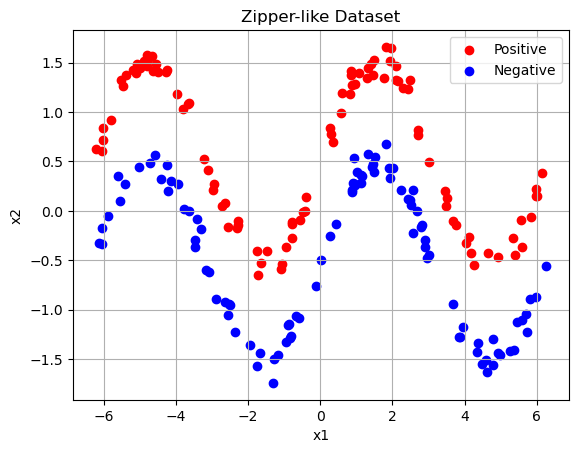

In [4]:
from vis_utils import visualize_2D_dataset

visualize_2D_dataset(x_train, y_train)

## Part 1: Support Vector Machine (10 pts)

在本部分，你将学习并完成SVM dual form的编写与训练。

在运行该部分代码前，请首先：

1. **补全kernels.py中三个kernel的代码；** (请首先阅读Base_kernel类的注释)

2. **补全SVM.py中SVM的predict函数；**

In [4]:
from SVM import SVM
from kernels import Linear_kernel, Polynomial_kernel, RBF_kernel

kernel_fn = Linear_kernel()
svm = SVM(kernel_fn=kernel_fn)

## Part 2: Simplified SMO (10 pts)

为了对SVM进行训练，我们需要对以下目标函数进行优化：




\begin{aligned}
 \max_{\alpha}&\ \  W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \kappa ( x^{(i)}, x^{(j)})  \\
 \text{subject to}& \ \ 0 \leq \alpha_i \leq C, \quad i = 1, \ldots, m \\
&\ \ \sum_{i=1}^{m} \alpha_i y^{(i)} = 0
\end{aligned}


一种常用的优化SVM的算法叫做SMO，全称是序列最小优化(Sequential Minimal Optimization)。它是由Platt于1998年提出的，用于高效地解决上述的二次规划问题。

SMO采取的策略是：多次迭代优化，每一次优化时仅优化两个变量，而固定其他变量。选择两个变量的原因是因为我们有一个线性的等式约束，这使得给定一个变量，另一个变量就可以由它确定。这样，问题就简化为本质上只有一个变量的优化问题，它可以通过解析方法得到解决。

SMO算法的工作流程如下：

1. 采用heuristic选择两个待优化的变量：一种常见的方法是选择违反KKT条件最严重的变量作为第一个变量，进一步选择使得目标函数值改变最大的变量作为第二个变量。

2. 固定其他变量，对这两个变量通过解析方法进行优化。（本质上是一个2 order polynomial的优化问题）

3. 检查是否所有变量都满足KKT条件：如果满足，则算法停止；否则，返回到第一步。

在实际应用中，SMO算法通过反复地选择和优化两个变量，直到整个数据集都满足KKT条件或满足一定的停止标准。由于每次都是解决一个简化的问题，SMO算法通常可以很快地收敛到最优解。



在本部分，我们将编写一种**简化版的SMO算法**，称为Simplified SMO。其简化之处主要在于上述工作流程中的第一步，即如何选取这两个待优化的变量上。在Simplified SMO中，我们采用的策略是：

1. 首先遍历所有的变量，直到找到第一个违反KKT条件的变量 $\alpha_i$，将其作为第一个待优化的变量；

2. 从所有其他变量中随机选择一个变量 $\alpha_j$ 作为第二个待优化的变量。

3. 在完成针对于这两个变量的优化后，从 $\alpha_i$ 开始继续遍历。若 $\alpha_i$ 已是最后一个变量，则从第一个变量开始重新遍历。

相比于SMO，Simplified SMO无法保证总是能优化到全局最优点，因为其无法保证对每一对变量都进行优化。然而，其能保证在绝大多数情况下均能收敛到不错的解。（注意，由于你每一次都是在做优化，因此你的objective function值应该总是在不断变小的。）

**请你来补全SSMO.py中SSMO_optimizer.fit中的循环代码。**

注意：

1. judge_violoate_KKT(), compute_E(), compute_eta(), compute_new_aj() when eta < 0, compute_b(), update_SVM()等已给出，你可以直接调用，请首先完成这些函数及其注释的阅读。

2. **compute_L_H(), compute_new_aj() when eta > 0, compute_new_ai 三个函数的代码未给出，需要你根据TODO处的要求来补全。**



采用Simplified SMO算法，我们可以对SVM进行训练。请运行下面的代码进行训练。若你的代码正确，你将会看到每一个pass的loss均在单调下降。

In [5]:
from SSMO import SSMO_optimizer
C = 1.0
max_passes = 1000

optimizer = SSMO_optimizer(C=C)
optimizer.fit(svm, x_train, y_train, max_passes=max_passes, verbose=True)

Start training using SMO


0it [00:00, ?it/s]

loss: -96.9191: : 1000it [00:11, 84.51it/s]

Training finished


训练完成后，我们可以利用训练得到的分类器来进行预测。请编写代码，计算训练集、测试集中的预测准确率。

In [6]:
# TODO: Implement the code to compute the accuracy of svm in the test set. 
# Note that svm itself is already trained, if you have run the above code.
_, predictions = svm.predict(x_test)
correct_predictions = np.sum(predictions == y_test)
accuracy = correct_predictions / len(y_test)
accuracy

0.64

可以看到，模型的预测准确率并不高。这主要是因为我们采用了**线形kernel**，而zipper数据集并不是线形可分的。为了更直观地看到我们的训练情况，请运行以下代码来查看SVM在训练集附近的分类热力图、分类边界以及测试集数据点。

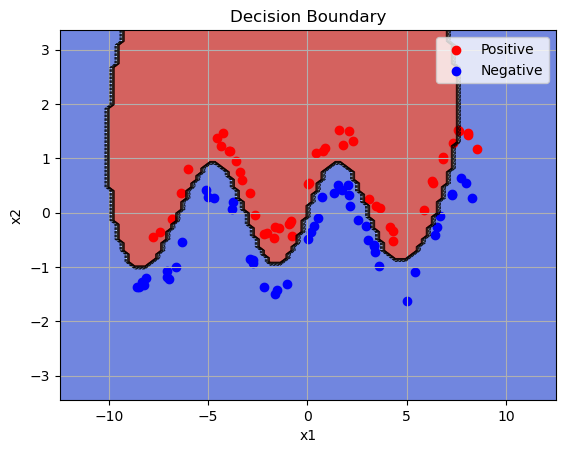

In [13]:
from vis_utils import visualize_2D_border

x1_intervals = (x_train[:, 0].min(), x_train[:, 0].max())
x2_intervals = (x_train[:, 1].min(), x_train[:, 1].max())

# expand 2.0 times
x1_mean = x1_intervals[0] + (x1_intervals[1] - x1_intervals[0]) / 2
x2_mean = x2_intervals[0] + (x2_intervals[1] - x2_intervals[0]) / 2

x1_intervals = (x1_mean - (x1_mean - x1_intervals[0]) * 2.0, x1_mean + (x1_intervals[1] - x1_mean) * 2.0)
x2_intervals = (x2_mean - (x2_mean - x2_intervals[0]) * 2.0, x2_mean + (x2_intervals[1] - x2_mean) * 2.0)

visualize_2D_border(svm, x1_intervals, x2_intervals, x_test, y_test)

接下来，清你自行编写代码，通过调整kernel类型、kernel参数、C值来提高模型的预测准确率。你可以仿照上述代码，来查看不同参数下的分类热力图、分类边界以及测试集数据点。

**请将训练准确率提升到99%以上，将测试集准确率提升到95%以上**

注意：每次修改参数后，需要重新初始化svm, optimizer 并调用optimizer.fit()来进行训练。

In [12]:
# TODO: Implement the code to improve the accuracy of svm in the training and test set.
from SVM import SVM
from kernels import Linear_kernel, Polynomial_kernel, RBF_kernel
from SSMO import SSMO_optimizer
from sklearn.model_selection import GridSearchCV

kernel_fn = RBF_kernel(1.9)
svm = SVM(kernel_fn=kernel_fn)

C = 2
max_passes = 1000

optimizer = SSMO_optimizer(C=C)
optimizer.fit(svm, x_train, y_train, max_passes=max_passes, verbose=True)

_, predictions = svm.predict(x_train)
correct_predictions = np.sum(predictions == y_train)
train_accuracy = correct_predictions / len(y_train)

_, predictions = svm.predict(x_test)
correct_predictions = np.sum(predictions == y_test)
test_accuracy = correct_predictions / len(y_test)
train_accuracy, test_accuracy

# RBF 3 3 0.98 0.92


Start training using SMO


loss: -70.1161: : 1000it [00:08, 120.64it/s]


Training finished


(1.0, 0.95)

In [ ]:
class MySVM(SVM):
    def __init__(self):
        self.C = None
        self.gamma = None
        self.kernel_fn = None

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.kernel_fn = RBF_kernel(self.gamma)
        return self

    def fit(self, X, y):
        if self.C is None or self.gamma is None:
            raise ValueError("C and gamma must be set before calling fit.")
        # 这里应该有一些代码来设置或重置SVM，因为C和gamma可能已经改变了
        optimizer = SSMO_optimizer(C=self.C)
        optimizer.fit(self, X, y, max_passes=1000, verbose=True)

    def score(self, X, y):
        _, predictions = self.predict(X)
        correct_predictions = np.sum(predictions == y)
        accuracy = correct_predictions / len(y)
        return accuracy
    
param_grid = {
    'C': np.arange(2, 3, 0.05),
    'gamma': np.arange(2, 3, 0.05)
}
print(param_grid)

# 使用网格搜索
grid_search = GridSearchCV(MySVM(), param_grid, cv=5)  # 使用5折交叉验证
grid_search.fit(x_train, y_train)

# 找到最佳参数
best_params = grid_search.best_params_
best_C = best_params['C']
best_gamma = best_params['gamma']

# 使用最佳参数训练最终模型
best_svm = MySVM(C=best_C, gamma=best_gamma)
best_svm.fit(x_train, y_train)

# 评估测试集上的性能
test_accuracy = best_svm.score(x_test, y_test)
print(f"Best C: {best_C}, Best Gamma: {best_gamma}, Test Accuracy: {test_accuracy}")